# statsmodels.regression.linear_model.OLS

公式ドキュメントは[こちら](https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.html)

### 紹介する機能

- OLS
- 2SLS



### Import

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.sandbox.regression.gmm as gmm
import pandas as pd
from patsy import dmatrices
import sys

### 環境

In [2]:
print(sys.version)

3.7.4 (default, Sep  7 2019, 18:45:40) 
[Clang 9.0.0 (clang-900.0.39.2)]


### Parameters

|param|説明|
|---|---|
|endog|array_like, dependent variable|
|exog|array_like, regressors|
|missing|str, ‘drop’, and ‘raise’. If ‘none’, no nan checking is done. If ‘drop’, any observations with nans are dropped. If ‘raise’, an error is raised. Default is ‘none’|

- results from Acemoglu, Johnson and Robinson’s seminal paper
- [here](https://economics.mit.edu/files/4123)

In [3]:
plt.style.use('ggplot')

In [4]:
df1 = pd.read_stata('https://github.com/QuantEcon/lecture-source-py/blob/master/source/_static/lecture_specific/ols/maketable1.dta?raw=true')
df1.head()

,shortnam,euro1900,excolony,avexpr,logpgp95,cons1,cons90,democ00a,cons00a,extmort4,logem4,loghjypl,baseco
0,AFG,0.000000,1.0,NaN,NaN,1.0,2.0,1.0,1.0,93.699997,4.540098,NaN,NaN
1,AGO,8.000000,1.0,5.363636,7.770645,3.0,3.0,0.0,1.0,280.000000,5.634789,-3.411248,1.0
2,ARE,0.000000,1.0,7.181818,9.804219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ARG,60.000004,1.0,6.386364,9.133459,1.0,6.0,3.0,3.0,68.900002,4.232656,-0.872274,1.0
4,ARM,0.000000,0.0,NaN,7.682482,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


relationship exists between GDP per capita and the protection against expropriation index

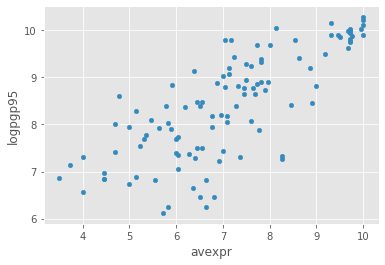

In [5]:
df1.plot(x='avexpr', y='logpgp95', kind='scatter')
plt.show()

Regression model

$$
{logpgp95}_i = \beta_0 + \beta_1 {avexpr}_i + u_i
$$

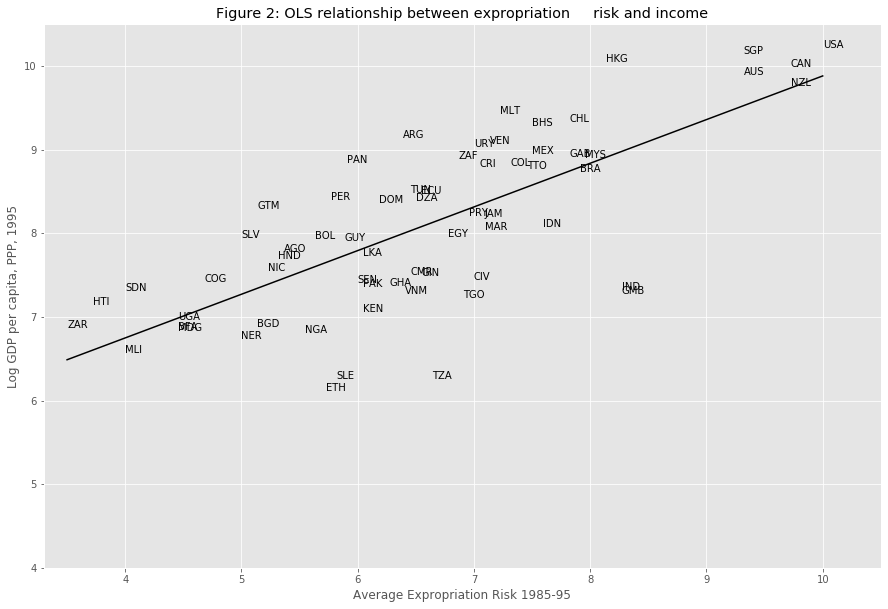

In [6]:
df1_subset = df1.copy()
# Use only 'base sample' for plotting purposes
df1_subset = df1_subset[df1_subset['baseco'] == 1]
X = df1_subset['avexpr']
y = df1_subset['logpgp95']
labels = df1_subset['shortnam']

# Replace markers with country labels
fig, ax = plt.subplots(figsize = (15, 10))
ax.scatter(X, y, marker='')

for i, label in enumerate(labels):
    ax.annotate(label, (X.iloc[i], y.iloc[i]))

# Fit a linear trend line
ax.plot(np.unique(X),
         np.poly1d(np.polyfit(X, y, 1))(np.unique(X)),
         color='black')

ax.set_xlim([3.3,10.5])
ax.set_ylim([4,10.5])
ax.set_xlabel('Average Expropriation Risk 1985-95')
ax.set_ylabel('Log GDP per capita, PPP, 1995')
ax.set_title('Figure 2: OLS relationship between expropriation \
    risk and income')
plt.show()

In [7]:
mod = smf.ols(formula='logpgp95 ~ avexpr', data = df1_subset, missing = 'drop')
results = mod.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               logpgp95   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.533
Method:                 Least Squares   F-statistic:                     72.82
Date:                Fri, 06 Mar 2020   Prob (F-statistic):           4.72e-12
Time:                        15:35:08   Log-Likelihood:                -68.168
No. Observations:                  64   AIC:                             140.3
Df Residuals:                      62   BIC:                             144.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.6604      0.409     11.408      0.0

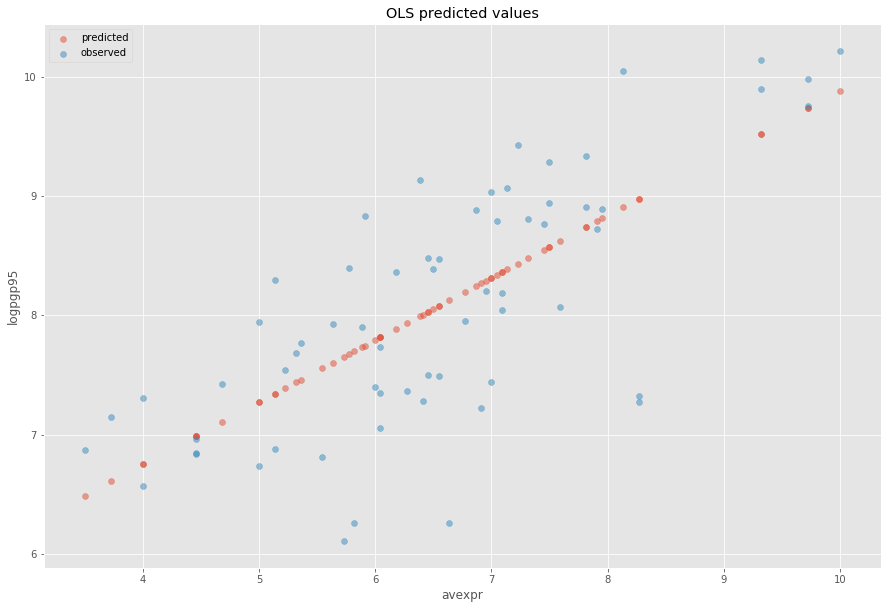

In [8]:
# Drop missing observations from whole sample

df1_plot = df1_subset.dropna(subset=['logpgp95', 'avexpr'])

# Plot predicted values

fix, ax = plt.subplots(figsize = (15, 10))
ax.scatter(df1_plot['avexpr'], results.predict(), alpha=0.5,label='predicted')

# Plot observed values

ax.scatter(df1_plot['avexpr'], df1_plot['logpgp95'], alpha=0.5,
        label='observed')

ax.legend()
ax.set_title('OLS predicted values')
ax.set_xlabel('avexpr')
ax.set_ylabel('logpgp95')
plt.show()

## 2SLS

In [9]:
y, X = dmatrices("logpgp95 ~ avexpr + logem4", data = df1_subset.dropna(subset = ['logpgp95', 'avexpr', 'logem4']), return_type = "dataframe")

In [10]:
mod = gmm.IV2SLS(endog = y,
                 exog = X.loc[:,['Intercept', 'avexpr']],
                 instrument = X.loc[:,['Intercept', 'logem4']])
res = mod.fit()
print(res.summary())

                          IV2SLS Regression Results                           
Dep. Variable:               logpgp95   R-squared:                       0.187
Model:                         IV2SLS   Adj. R-squared:                  0.174
Method:                     Two Stage   F-statistic:                     36.39
                        Least Squares   Prob (F-statistic):           9.80e-08
Date:                Fri, 06 Mar 2020                                         
Time:                        15:35:08                                         
No. Observations:                  64                                         
Df Residuals:                      62                                         
Df Model:                           1                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.9097      1.027      1.860      0.0